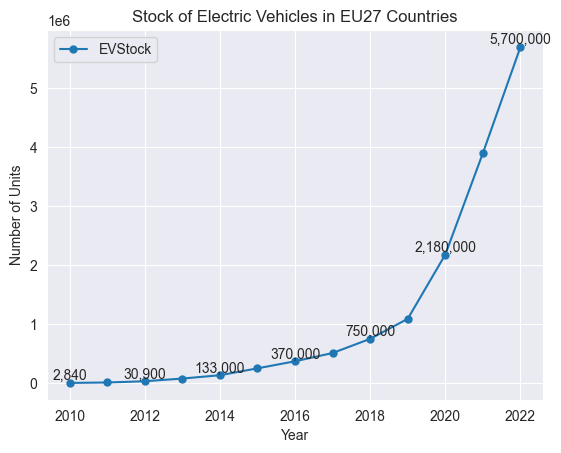

In [464]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("IEA Global EV Data 2023.csv")




result = df.loc[(df['region'] == 'EU27') & (df['category'] == 'Historical') & (df['parameter'] == 'EV stock') & (df['mode'] == 'Cars') ].groupby(["year"]).agg(EVStock=('value', 'sum'))

# plotting a line graph 
fig, ax = plt.subplots()

n = 2 # Variable to Adjust the data point marking gaps
ax.plot(result.index, result['EVStock'], marker='o', markersize=5, label='EVStock')

for i, (year, ev_stock) in enumerate(result['EVStock'].items()):
    if i % n == 0:
        ax.text(year, ev_stock, "{:,.0f}".format(ev_stock), ha="center", va="bottom")

plt.xlabel('Year')
plt.ylabel('Number of Units')
plt.legend()
plt.title("Stock of Electric Vehicles in EU27 Countries")
plt.show()


In [426]:
import psycopg2 

createString = """
CREATE TABLE IF NOT EXISTS GLOBAL_EV_DATA (
Region	varchar(50),
Category varchar(50),
Parameter	varchar(50),
Mode	varchar(200),
Powertrain	varchar(50),
Year	integer,
unit	varchar(300),
value	numeric
);
"""

readdata = '''select count(*) from GLOBAL_EV_DATA;'''


In [427]:
try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("drop table GLOBAL_EV_DATA;")
    dbCursor.execute(createString)
    dbCursor.execute(readdata)
    print (dbCursor.fetchall())
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[(0,)]


In [428]:
import csv


try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertString = "INSERT INTO GLOBAL_EV_DATA VALUES ('{}'," + "'{}',"*6 + "{})"

    print(insertString)
    with open('IEA Global EV Data 2023.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString.format(*row))
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

INSERT INTO GLOBAL_EV_DATA VALUES ('{}','{}','{}','{}','{}','{}','{}',{})


In [429]:
totalEVStock_Cars = '''Select Year,  
    Sum(Value) as TotalEVCars
    from GLOBAL_EV_DATA
    where Region = 'EU27' and Category = 'Historical' and Parameter = 'EV stock' and mode = 'Cars'
    group by  Year
'''


totalEVStock_Percent = '''Select Year,  
    Value as TotalEVCarsPercentage
    from GLOBAL_EV_DATA
    where Region = 'EU27' and Category = 'Historical' and Parameter = 'EV stock share' and mode = 'Cars'
'''


try:
    dbConnection = psycopg2.connect(user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(totalEVStock_Cars)
    allEVCars = dbCursor.fetchall(); 
    for i in allEVCars: 
        print(i) 
    dbCursor.execute(totalEVStock_Percent)
    allEVCarsPercentage = dbCursor.fetchall(); 
    for i in allEVCarsPercentage: 
        print(i) 
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()


(2010, Decimal('2840'))
(2011, Decimal('10430'))
(2012, Decimal('30900'))
(2013, Decimal('77000'))
(2014, Decimal('133000'))
(2015, Decimal('250000'))
(2016, Decimal('370000'))
(2017, Decimal('510000'))
(2018, Decimal('750000'))
(2019, Decimal('1090000'))
(2020, Decimal('2180000'))
(2021, Decimal('3900000'))
(2022, Decimal('5700000'))
(2010, Decimal('0.00139999995008111'))
(2011, Decimal('0.004999999888241291'))
(2012, Decimal('0.014000000432133675'))
(2013, Decimal('0.03500000014901161'))
(2014, Decimal('0.05999999865889549'))
(2015, Decimal('0.10999999940395355'))
(2016, Decimal('0.17000000178813934'))
(2017, Decimal('0.23000000417232513'))
(2018, Decimal('0.33000001311302185'))
(2019, Decimal('0.44999998807907104'))
(2020, Decimal('0.8600000143051147'))
(2021, Decimal('1.600000023841858'))
(2022, Decimal('2.299999952316284'))


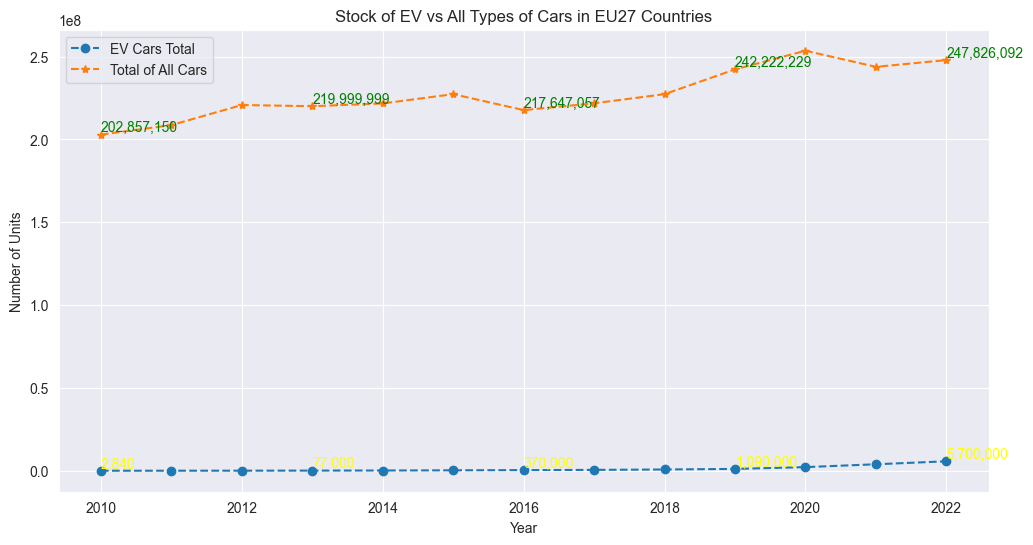

In [472]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(allEVCars, columns =['Year', 'EVCars'])
sorted_df_cars = df.sort_values('Year').reindex()

df1 = pd.DataFrame(allEVCarsPercentage, columns =['Year', 'EVCarsPercentage'])
sorted_df_all = df1.sort_values('Year').reindex()

df_combined = pd.merge(sorted_df_cars, sorted_df_all, on='Year')

# using apply function to create a new column
df_combined['AllCars_Total'] = df_combined.apply(lambda row: 100*row.EVCars/row.EVCarsPercentage, axis = 1)

df_combined.set_index("Year", inplace=True)

#print(df_combined)

plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['EVCars'], label = 'EV Cars Total', linestyle='--', marker='o')
plt.plot(df_combined.index, df_combined['AllCars_Total'], label = 'Total of All Cars', linestyle='--', marker='*')

n = 3 # Variable to Adjust the data point marking gaps

for i, (year, ev_cars, all_cars) in enumerate(zip(df_combined.index, df_combined['EVCars'], df_combined['AllCars_Total'])):
    if i % n == 0:
        plt.text(year, ev_cars, f'{ev_cars:,.0f}', ha='left', va='bottom', color='yellow')
        plt.text(year, all_cars, f'{all_cars:,.0f}', ha='left', va='bottom', color='green')

plt.title("Stock of EV vs All Types of Cars in EU27 Countries")
plt.xlabel('Year')
plt.ylabel('Number of Units')
plt.legend()
plt.show()




C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


2010
[2023 2024 2025 2026 2027 2028 2029 2030 2031 2032]


C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


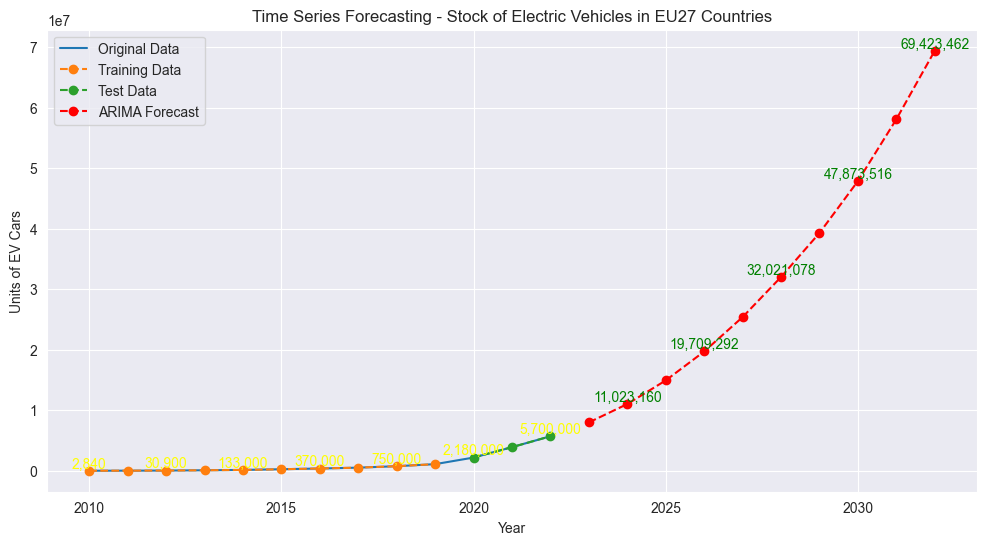

Year
2020    2180000
2021    3900000
2022    5700000
Name: EVCars, dtype: object
[ 7991620.27883415 11023160.06664828 14929760.53783554 19709291.70134597
 25396310.10564318 32021077.78120251 39294765.9618478  47873516.00969863
 58087927.04739292 69423461.72166048]


In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df_raw = df_combined

# Plot the original time series data
'''
plt.figure(figsize=(10, 6))
plt.plot(df_raw.index, df['EVCars'], label='Original Data')
plt.title('Electric Vehicles Dataset')
plt.xlabel('Year')
plt.ylabel('EVCars')
plt.legend()
plt.show()
'''
# Splitting the data into training and testing sets
train_size = int(len(df_raw) * 0.8)
train, test = df_raw[:train_size], df_raw[train_size:]


# Fit ARIMA model
order = (8,2,1)  # ARIMA parameters (p, d, q)
model = ARIMA(df_raw['EVCars'].astype(float), order=order)
fit_model = model.fit()

forecast_steps = 10  # Adjust the number of steps as needed

# Forecasting
forecast = fit_model.get_forecast(steps=forecast_steps)
conf_int = forecast.conf_int()
forecast_values = forecast.predicted_mean

print(df_raw.index.min())
# Extend the time index for plotting
forecast_index = np.arange(df_raw.index.max() +1, df_raw.index.max() + forecast_steps + 1)

print(forecast_index)


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_raw.index, df_raw['EVCars'], label='Original Data')
plt.plot(train.index, train['EVCars'], label='Training Data', linestyle='--', marker='o')
plt.plot(test.index, test['EVCars'], label='Test Data', linestyle='--', marker='o')

# Plot the ARIMA Forecast along with confidence interval
plt.plot(forecast_index[-forecast_steps:], forecast_values, label='ARIMA Forecast', color='red', linestyle='--', marker='o')

n = 2  

for i, (year, ev_cars) in enumerate(zip(df_raw.index, df_raw['EVCars'])):
    if i % n == 0:
        plt.text(year, ev_cars, f'{ev_cars:,.0f}', ha='center', va='bottom', color='yellow')

for year, forecast_value in zip(forecast_index[-forecast_steps:], forecast_values):
    if year % n == 0:
        plt.text(year, forecast_value, f'{forecast_value:,.0f}', ha='center', va='bottom', color='green')


plt.title('Time Series Forecasting - Stock of Electric Vehicles in EU27 Countries')
plt.xlabel('Year')
plt.ylabel('Units of EV Cars')
plt.legend()
plt.show()

print(test['EVCars'])
print(forecast_values.to_numpy())


C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rames\PycharmProjects\pyt

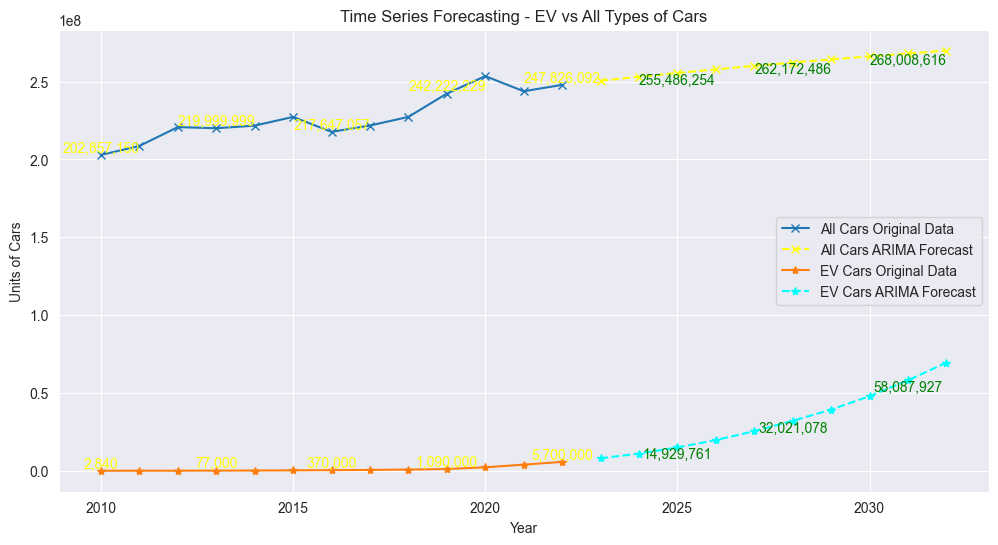

Year
2020    253488367.8765346772213674463
2021    243749996.3678419994358720519
2022    247826092.0944647794879581379
Name: AllCars_Total, dtype: object
[2.50496052e+08 2.53047692e+08 2.55486254e+08 2.57816749e+08
 2.60043968e+08 2.62172486e+08 2.64206677e+08 2.66150722e+08
 2.68008616e+08 2.69784176e+08]


In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df_allCars = df_combined

# Splitting the data into training and testing sets
train_size_all_cars = int(len(df_allCars) * 0.8)
train_all_cars, test_all_cars = df_allCars[:train_size_all_cars], df_allCars[train_size_all_cars:]


# Fit ARIMA model
order_all_cars = (1,1,1)  # ARIMA parameters (p, d, q)
model_all_cars = ARIMA(df_allCars['AllCars_Total'].astype(float), order=order_all_cars)
fit_model_all_cars = model_all_cars.fit()

print(df_allCars)

forecast_steps_all_cars = 10  # Adjust the number of steps as needed

# Forecasting
forecast_all_cars = fit_model_all_cars.get_forecast(steps=forecast_steps_all_cars)
conf_int = forecast_all_cars.conf_int()
forecast_values_all_cars = forecast_all_cars.predicted_mean

#print(df_allCars.index.min())
# Extend the time index for plotting
forecast_index_all_cars = np.arange(df_allCars.index.max() +1, df_allCars.index.max() + forecast_steps_all_cars + 1)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_allCars.index, df_allCars['AllCars_Total'], label='All Cars Original Data', marker='x')
#plt.plot(train_all_cars.index, train_all_cars['AllCars_Total'], label='All Cars Training Data', linestyle='--', marker='o')
#plt.plot(test_all_cars.index, test_all_cars['AllCars_Total'], label='All Cars Test Data', linestyle='--', marker='o')

# Plot the ARIMA Forecast along with confidence interval
plt.plot(forecast_index_all_cars[-forecast_steps_all_cars:], forecast_values_all_cars, label='All Cars ARIMA Forecast', color='yellow', linestyle='--', marker='x')


plt.plot(df_raw.index, df_raw['EVCars'], label='EV Cars Original Data', marker='*')
#plt.plot(train.index, train['EVCars'], label='EV Cars Training Data', linestyle='--', marker='*')
#plt.plot(test.index, test['EVCars'], label='EV Cars Test Data', linestyle='--', marker='*')

# Plot the ARIMA Forecast along with confidence interval
plt.plot(forecast_index[-forecast_steps:], forecast_values, label='EV Cars ARIMA Forecast', color='cyan', linestyle='--', marker='*')

n = 3 # Variable to Adjust the data point marking gaps

for i, (year, ev_cars, all_cars) in enumerate(zip(df_combined.index, df_combined['EVCars'], df_combined['AllCars_Total'])):
    if i % n == 0:
        plt.text(year, ev_cars, f'{ev_cars:,.0f}', ha='center', va='bottom', color='yellow')
        plt.text(year, all_cars, f'{all_cars:,.0f}', ha='center', va='bottom', color='yellow')


n = 3  

for year, forecast_value, forecast_value_all_cars in zip(forecast_index[-forecast_steps:], forecast_values, forecast_values_all_cars):
    if year % n == 0:
        plt.text(year, forecast_value, f'{forecast_value:,.0f}', ha='center', va='top', color='green')
        plt.text(year, forecast_value_all_cars, f'{forecast_value_all_cars:,.0f}', ha='center', va='top', color='green')


plt.title('Time Series Forecasting - EV vs All Types of Cars')
plt.xlabel('Year')
plt.ylabel('Units of Cars')
plt.legend()
plt.show()

print(test_all_cars['AllCars_Total'])
print(forecast_values_all_cars.to_numpy())


In [433]:
import pandas as pd

df_final = pd.DataFrame(forecast_index, columns=['Year'])
df_final['EVCars'] = forecast_values.values
df_final['AllCars_Total'] = forecast_values_all_cars.values

df_final['EVCarsPercentage'] = 100*df_final['EVCars']/df_final['AllCars_Total']
df_final.set_index("Year", inplace=True)

df_final = df_final[df_combined.columns]
df_actual_and_predicted = pd.concat([df_combined, df_final])

print(df_final)
print(df_combined)
print(df_actual_and_predicted)


            EVCars  EVCarsPercentage  AllCars_Total
Year                                               
2023  7.991620e+06          3.190318   2.504961e+08
2024  1.102316e+07          4.356159   2.530477e+08
2025  1.492976e+07          5.843665   2.554863e+08
2026  1.970929e+07          7.644690   2.578167e+08
2027  2.539631e+07          9.766160   2.600440e+08
2028  3.202108e+07         12.213745   2.621725e+08
2029  3.929477e+07         14.872738   2.642067e+08
2030  4.787352e+07         17.987370   2.661507e+08
2031  5.808793e+07         21.673903   2.680086e+08
2032  6.942346e+07         25.732963   2.697842e+08
       EVCars      EVCarsPercentage                  AllCars_Total
Year                                                              
2010     2840   0.00139999995008111  202857150.0902884007647119615
2011    10430  0.004999999888241291  208600004.6625734436966377370
2012    30900  0.014000000432133675  220714278.9015662523779437217
2013    77000   0.03500000014901161  2199

In [438]:
import psycopg2 

createActualAndForecastString = """
CREATE TABLE IF NOT EXISTS EU_CARS_ACTUAL_AND_FORECAST (
Year	integer,
EVCars	numeric,
EVCarsPercentage	numeric,
AllCars_Total	numeric
);
"""

readActualAndForecastString = '''select * from EU_CARS_ACTUAL_AND_FORECAST;'''


try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #dbCursor.execute("drop table EU_CARS_ACTUAL_AND_FORECAST;")
    dbCursor.execute(createActualAndForecastString)
    dbCursor.execute(readActualAndForecastString)
    print (dbCursor.fetchall())
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[]


In [439]:
import csv


try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    insertStringActualAndForecast = "INSERT INTO EU_CARS_ACTUAL_AND_FORECAST VALUES ({},{},{},{})"

    print(insertStringActualAndForecast)

    for index,row in df_actual_and_predicted.iterrows() :
        #print(row)
        dbCursor.execute(insertStringActualAndForecast.format(index, row['EVCars'], row['EVCarsPercentage'], row['AllCars_Total']))    
    
    dbCursor.close()
    dbConnection.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

INSERT INTO EU_CARS_ACTUAL_AND_FORECAST VALUES ({},{},{},{})


In [440]:
try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()

    dbCursor.execute(readActualAndForecastString)    
    print (dbCursor.fetchall())

    dbCursor.close()
    dbConnection.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[(2010, Decimal('2840'), Decimal('0.00139999995008111'), Decimal('202857150.0902884007647119615')), (2011, Decimal('10430'), Decimal('0.004999999888241291'), Decimal('208600004.6625734436966377370')), (2012, Decimal('30900'), Decimal('0.014000000432133675'), Decimal('220714278.9015662523779437217')), (2013, Decimal('77000'), Decimal('0.03500000014901161'), Decimal('219999999.0633555982734540085')), (2014, Decimal('133000'), Decimal('0.05999999865889549'), Decimal('221666671.6213028838003051590')), (2015, Decimal('250000'), Decimal('0.10999999940395355'), Decimal('227272728.5042282091523548550')), (2016, Decimal('370000'), Decimal('0.17000000178813934'), Decimal('217647056.5342160939762596841')), (2017, Decimal('510000'), Decimal('0.23000000417232513'), Decimal('221739126.4123142198506723437')), (2018, Decimal('750000'), Decimal('0.33000001311302185'), Decimal('227272718.2417208478406695172')), (2019, Decimal('1090000'), Decimal('0.44999998807907104'), Decimal('242222228.638919955860982